In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import heatmap, pairplot, kdeplot, PairGrid, color_palette
from cmocean import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['legend.fontsize'] = 16

In [6]:
data_path = os.path.join('./PickleJar/dfNomadRaw.pkl')

### <u>Load Raw Nomad Data and Extract Data for this Exercise</u>

In [7]:
df = pd.read_pickle(data_path)

### Compute Rrs from Lw and Es columns

In [8]:
lw_cols = df.filter(regex='lw').columns.tolist()
es_cols = df.filter(regex='es').columns.tolist()
rrs_cols = ['rrs%s' %band[2:] for band in lw_cols]

# make sure columns match in length
assert len(lw_cols) == len(es_cols) == len(rrs_cols)
df_rrs = pd.DataFrame(columns=rrs_cols)
for rrs, lw, es in zip(rrs_cols, lw_cols, es_cols):
    df_rrs[rrs] = df[lw].astype('f8') / df[es].astype('f8')
    
# validate entries
df_rrs[df_rrs<0] = np.NaN
df_rrs[df_rrs==1] = np.NaN

# copy index column
df_rrs.insert(0, 'id', df.id)

### Make new dataFrame with Rrs, other potential predictors, chl

In [9]:
rrs_cols = [col for col in df_rrs.columns if 'rrs' in col]
aop_cols_x = ['id', 'datetime']
aop_cols_x_floats = ['lat', 'lon', 'etopo2', 'oisst',
                   'wtemp', 'sal']
aop_cols_y_floats = ['fluo_chl', 'hplc_chl']
d_cols_x = ['id', 'Datetime']
d_cols_x_floats = ['lat' ,'lon', 'etopo2', 'oisst', 'wt', 'sal']
d_cols_y_floats = ['chl', 'chl_a']
d_aop = pd.DataFrame(columns=aop_cols_x + aop_cols_x_floats +
                     rrs_cols + aop_cols_y_floats)
d_aop[aop_cols_x] = df[d_cols_x]
d_aop[aop_cols_x_floats] = df[d_cols_x_floats].astype('f8')
d_aop[rrs_cols] = df_rrs[rrs_cols]
d_aop[aop_cols_y_floats] = df[d_cols_y_floats].astype('f8')

In [10]:
# more entry validation
d_aop[d_aop==-999] = np.NaN

In [11]:
d_aop.head().T

,0,1,2,3,4
id,1565,1566,1567,1568,1559
datetime,2003-04-15 15:15:00,2003-04-15 16:50:00,2003-04-15 17:50:00,2003-04-17 18:15:00,2003-07-21 18:27:00
lat,38.4279,38.368,38.3074,38.6367,38.3047
lon,-76.61,-76.5,-76.44,-76.32,-76.44
etopo2,0,0,1,3,1
oisst,3.7,3.7,3.7,3.7,22.03
wtemp,NaN,NaN,NaN,NaN,NaN
sal,NaN,NaN,NaN,NaN,NaN
rrs405,NaN,NaN,NaN,NaN,NaN
rrs411,0.0012044,0.00106171,0.000971132,0.0014718,0.000905091


#### Consolidate chlorophyll columns giving preference to hplc and flag chl source via  boolean 'is_hplc' column

In [12]:
def fill_chl(row):
    if np.isnan(row.hplc_chl):
        return row.fluo_chl
    else:
        return row.hplc_chl
    
d_aop['chl'] = d_aop.apply(fill_chl, axis=1)
d_aop.insert(d_aop.shape[1]-3, 'is_hplc', ~d_aop.hplc_chl.isnull())

In [13]:
d_aop.head().T

,0,1,2,3,4
id,1565,1566,1567,1568,1559
datetime,2003-04-15 15:15:00,2003-04-15 16:50:00,2003-04-15 17:50:00,2003-04-17 18:15:00,2003-07-21 18:27:00
lat,38.4279,38.368,38.3074,38.6367,38.3047
lon,-76.61,-76.5,-76.44,-76.32,-76.44
etopo2,0,0,1,3,1
oisst,3.7,3.7,3.7,3.7,22.03
wtemp,NaN,NaN,NaN,NaN,NaN
sal,NaN,NaN,NaN,NaN,NaN
rrs405,NaN,NaN,NaN,NaN,NaN
rrs411,0.0012044,0.00106171,0.000971132,0.0014718,0.000905091


In [14]:
d_aop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 32 columns):
id          4459 non-null object
datetime    4459 non-null datetime64[ns]
lat         4459 non-null float64
lon         4459 non-null float64
etopo2      4459 non-null float64
oisst       4459 non-null float64
wtemp       1235 non-null float64
sal         672 non-null float64
rrs405      12 non-null float64
rrs411      4293 non-null float64
rrs443      4456 non-null float64
rrs455      393 non-null float64
rrs465      375 non-null float64
rrs489      4422 non-null float64
rrs510      3435 non-null float64
rrs520      1559 non-null float64
rrs530      1589 non-null float64
rrs550      912 non-null float64
rrs555      3255 non-null float64
rrs560      1193 non-null float64
rrs565      1884 non-null float64
rrs570      816 non-null float64
rrs590      690 non-null float64
rrs619      883 non-null float64
rrs625      1884 non-null float64
rrs665      2641 non-null float64
rrs670      

In [15]:
d_aop.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,4459.0,1.868658,44.765125,-77.035600,-61.299000,27.093000,34.458500,79.690000
lon,4459.0,-61.592062,53.894958,-179.955000,-82.699950,-67.675000,-63.961500,179.907000
etopo2,4459.0,1312.346715,1766.435289,0.000000,18.000000,240.000000,2789.500000,7978.000000
oisst,4459.0,14.841534,10.374969,-1.800000,1.860000,16.380000,24.430000,30.890000
wtemp,1235.0,18.021513,8.203662,-1.880000,13.425000,18.090000,24.441000,36.250000
sal,672.0,28.717463,8.397708,0.080000,24.885000,33.250000,33.630000,37.010000
rrs405,12.0,0.006333,0.003972,0.001216,0.001838,0.006932,0.009987,0.011736
rrs411,4293.0,0.004881,0.003447,0.000051,0.002509,0.003984,0.006301,0.030600
rrs443,4456.0,0.004652,0.003002,0.000190,0.002617,0.003899,0.006076,0.036769
rrs455,393.0,0.003223,0.002901,0.000229,0.001604,0.002523,0.003985,0.040897


In [16]:
d_aop.to_pickle('./PickleJar/df_1_aop_anc.pkl')

### Extract SeaWiFS-like band data

In [17]:
columns = ['id', 'lat', 'lon', 'etopo2', 'oisst', 'wtemp', 'sal', 'rrs411', 'rrs443',
          'rrs489', 'rrs510', 'rrs555', 'rrs670', 'is_hplc', 'chl']
df_final = d_aop[columns]
df_final.insert(df_final.shape[1]-1, 'chl_log', np.log10(df_final.chl))

In [18]:
df_final.insert(df_final.shape[1]-2, 'MxBl2Gr_log', 
               np.log10(df_final.loc[:, ['rrs443','rrs489','rrs510']].max(axis=1)
                        / df_final.rrs555)
               )
df_final.insert(df_final.shape[1]-2, 'MxBlBand',
                df_final.loc[:, ['rrs443', 'rrs489', 'rrs510']].idxmax(axis=1)
               )

In [19]:
df_final.head().T

,0,1,2,3,4
id,1565,1566,1567,1568,1559
lat,38.4279,38.368,38.3074,38.6367,38.3047
lon,-76.61,-76.5,-76.44,-76.32,-76.44
etopo2,0,0,1,3,1
oisst,3.7,3.7,3.7,3.7,22.03
wtemp,NaN,NaN,NaN,NaN,NaN
sal,NaN,NaN,NaN,NaN,NaN
rrs411,0.0012044,0.00106171,0.000971132,0.0014718,0.000905091
rrs443,0.00168608,0.00138402,0.00118548,0.00174123,0.00102233
rrs489,0.00329309,0.00217292,0.0018432,0.00287731,0.00150593


In [20]:
df_final.to_pickle('./PickleJar/df_2_swf_final.pkl')

In [21]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 18 columns):
id             4459 non-null object
lat            4459 non-null float64
lon            4459 non-null float64
etopo2         4459 non-null float64
oisst          4459 non-null float64
wtemp          1235 non-null float64
sal            672 non-null float64
rrs411         4293 non-null float64
rrs443         4456 non-null float64
rrs489         4422 non-null float64
rrs510         3435 non-null float64
rrs555         3255 non-null float64
rrs670         1598 non-null float64
is_hplc        4459 non-null bool
MxBl2Gr_log    3255 non-null float64
MxBlBand       4459 non-null object
chl_log        4127 non-null float64
chl            4127 non-null float64
dtypes: bool(1), float64(15), object(2)
memory usage: 596.6+ KB


### Isolating features I will use for this paper

In [22]:
cols_1 = ['id', 'lat', 'lon', 'etopo2', 'oisst']
cols_2 = df_final.filter(regex='rrs', axis=1).columns.tolist()
cols_3 = ['is_hplc', 'MxBl2Gr_log', 'MxBlBand', 'chl_log' ,'chl']
cols = cols_1 + cols_2 + cols_3
df_f_p1 = df_final[cols]

In [23]:
df_f_p1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 16 columns):
id             4459 non-null object
lat            4459 non-null float64
lon            4459 non-null float64
etopo2         4459 non-null float64
oisst          4459 non-null float64
rrs411         4293 non-null float64
rrs443         4456 non-null float64
rrs489         4422 non-null float64
rrs510         3435 non-null float64
rrs555         3255 non-null float64
rrs670         1598 non-null float64
is_hplc        4459 non-null bool
MxBl2Gr_log    3255 non-null float64
MxBlBand       4459 non-null object
chl_log        4127 non-null float64
chl            4127 non-null float64
dtypes: bool(1), float64(13), object(2)
memory usage: 527.0+ KB


In [43]:
df_f_p1.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052 entries, 0 to 4458
Data columns (total 16 columns):
id             1052 non-null object
lat            1052 non-null float64
lon            1052 non-null float64
etopo2         1052 non-null float64
oisst          1052 non-null float64
rrs411         1052 non-null float64
rrs443         1052 non-null float64
rrs489         1052 non-null float64
rrs510         1052 non-null float64
rrs555         1052 non-null float64
rrs670         1052 non-null float64
is_hplc        1052 non-null bool
MxBl2Gr_log    1052 non-null float64
MxBlBand       1052 non-null object
chl_log        1052 non-null float64
chl            1052 non-null float64
dtypes: bool(1), float64(13), object(2)
memory usage: 132.5+ KB


In [44]:
df_f_p1_clean = df_f_p1.dropna()

In [ ]:
df_f_p1_clean.insert(df_f_p1_clean.shape[1]-3, 'MxBl2Gr_log_2', df_f_p1_clean.MxBl2Gr_log ** 2)

In [50]:
df_f_p1_clean.insert(df_f_p1_clean.shape[1]-3, 'MxBl2Gr_log_3', df_f_p1_clean.MxBl2Gr_log ** 3)
df_f_p1_clean.insert(df_f_p1_clean.shape[1]-3, 'MxBl2Gr_log_4', df_f_p1_clean.MxBl2Gr_log ** 4)

In [51]:
df_f_p1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052 entries, 0 to 4458
Data columns (total 19 columns):
id               1052 non-null object
lat              1052 non-null float64
lon              1052 non-null float64
etopo2           1052 non-null float64
oisst            1052 non-null float64
rrs411           1052 non-null float64
rrs443           1052 non-null float64
rrs489           1052 non-null float64
rrs510           1052 non-null float64
rrs555           1052 non-null float64
rrs670           1052 non-null float64
is_hplc          1052 non-null bool
MxBl2Gr_log      1052 non-null float64
MxBl2Gr_log_2    1052 non-null float64
MxBl2Gr_log_3    1052 non-null float64
MxBl2Gr_log_4    1052 non-null float64
MxBlBand         1052 non-null object
chl_log          1052 non-null float64
chl              1052 non-null float64
dtypes: bool(1), float64(16), object(2)
memory usage: 157.2+ KB


/home/madhatter106/anaconda3/envs/ML/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


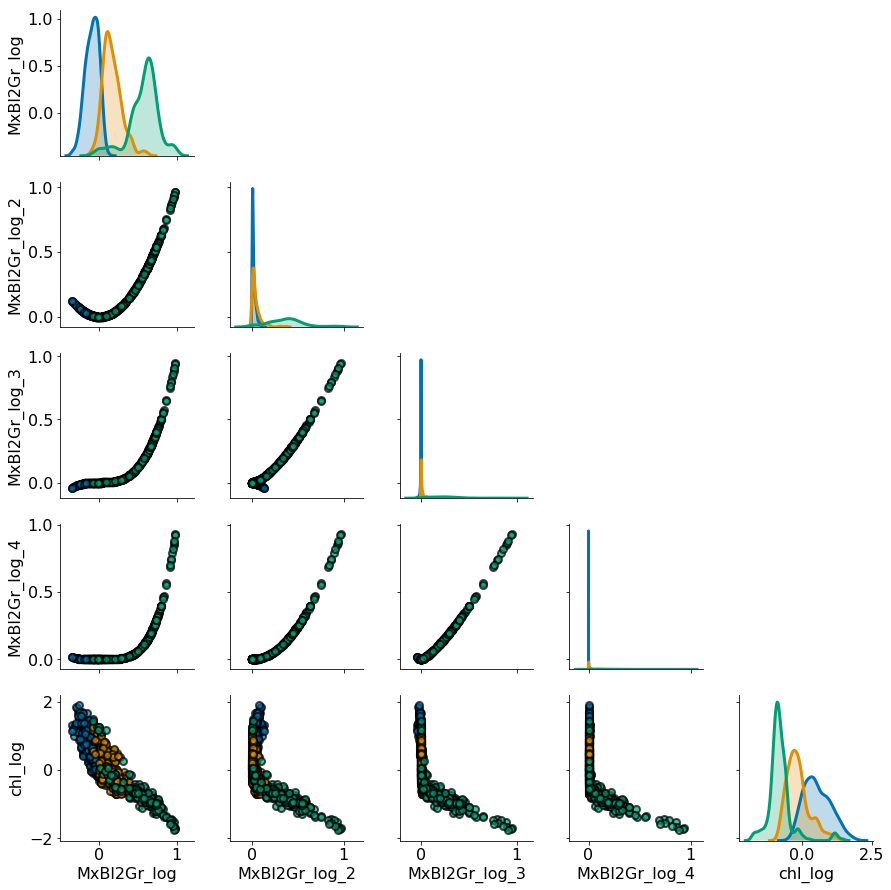

In [58]:
g = PairGrid(df_f_p1_clean[['MxBlBand', 'MxBl2Gr_log', 'MxBl2Gr_log_2', 
                            'MxBl2Gr_log_3', 'MxBl2Gr_log_4', 'chl_log']],
                 hue="MxBlBand", height=2.5, diag_sharey=False,
             palette=color_palette('colorblind', n_colors=3))
g = g.map_diag(kdeplot, shade=True, linewidth=3) kdeplot()
g = g.map_offdiag(pl.scatter, alpha=0.7, edgecolor='k', s=50, linewidth=2,)
#g.add_legend()
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
pl.legend(loc='best', facecolor='gray')
f = pl.gcf()
f.savefig('./FigJar/OC4PairWise.pdf', dpi=300, format='pdf')

### Splitting the data into training & testing sets
After splitting, I'll stash the test set away and come back to it after models have been fit with the training data

In [38]:
x_train, x_test, y_train, y_test = train_test_split(df_f_p1.dropna().loc[:, :'MxBlBand'],
                                                   df_f_p1.dropna().loc[:, 'chl_log':],
                                                   test_size=0.10, random_state=42)

In [39]:
with open('./PickleJar/test_set_paper_1.pkl', 'wb') as fb:
    test_dict = dict(x=x_test, y=y_test)

with open('./PickleJar/train_set_paper_1.pkl', 'wb') as fb:
    train_dict = dict(x=x_train, y=y_train)

### Making PCs out of Rrs - two ways
##### 1 - PC our straight Rrs
steps:

a) initialize and parameterize standard scaler with rrs from training set

b) stash standard scaler for later transformation of test set

c) compute pc from standardized rrs of training set

d) stash pc transformer for step 2 in transformation of test set

e) initialize and parameterize second standard scaler with pc from c)

f) stash second standardizer for step 3 in transformation of test set

##### 2 - PC from band-normalized Rrs to reflect the spectral structure
steps:

a) band normalize rrs (divide each observation by the row sum)

b) initialize and parameterize standard scaler with rrs from training set

c) stash standard scaler for later transformation of test set

d) compute pc from standardized rrs of training set

e) stash pc transformer for step 2 in transformation of test set

f) initialize and parameterize second standard scaler with pc from d)

g) stash second standardizer for step 3 in transformation of test set

#### 1 - PC from straight Rrs

In [53]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 946 entries, 4417 to 4071
Data columns (total 14 columns):
id             946 non-null object
lat            946 non-null float64
lon            946 non-null float64
etopo2         946 non-null float64
oisst          946 non-null float64
rrs411         946 non-null float64
rrs443         946 non-null float64
rrs489         946 non-null float64
rrs510         946 non-null float64
rrs555         946 non-null float64
rrs670         946 non-null float64
is_hplc        946 non-null bool
MxBl2Gr_log    946 non-null float64
MxBlBand       946 non-null object
dtypes: bool(1), float64(11), object(2)
memory usage: 104.4+ KB


In [34]:
cols = ['etopo2', 'oisst'] + x_train.filter(regex='rrs', axis=1).columns.tolist() + ['chl_log']
d = pd.concat((x_train))
pairplot(np.log10(x_train[cols]+1e-6))

KeyError: "['MxBl2Gr'] not in index"

In [29]:
x_train.head()

,id,lat,lon,etopo2,oisst,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,is_hplc,MxBl2Gr_log,MxBlBand
3604,1334,38.50130,-76.3942,16.0,14.25,0.001247,0.001760,0.002808,0.003147,NaN,0.001841,False,NaN,rrs510
2857,5678,-64.81500,-64.0410,28.0,0.77,0.003385,0.002567,0.002907,0.002754,0.002129,NaN,False,0.135239,rrs489
1411,2095,27.46530,-82.7536,1.0,27.14,0.001100,0.001400,0.002400,0.002900,0.004400,0.001500,False,-0.181060,rrs510
1840,4236,7.30800,85.1660,3827.0,29.95,0.011078,0.008482,0.006093,0.003736,0.001502,NaN,False,0.751863,rrs443
1729,2680,9.97645,-55.9629,3799.0,29.20,0.001763,0.002375,0.003063,0.002479,0.001790,0.000118,False,0.233185,rrs489


In [ ]:
sc1_1 = StandardScaler()


##### 2 - PC out of band-normalized Rrs

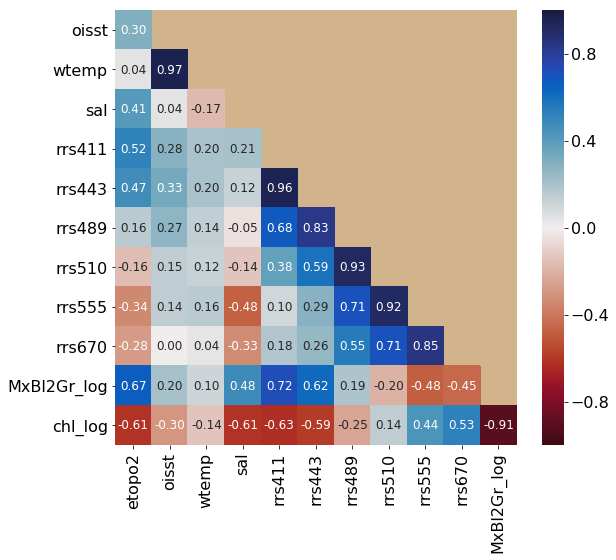

In [113]:
corr_columns = ['etopo2', 'oisst', 'wtemp', 'sal'] +\
               [col for col in df_final.columns.tolist() if 'rrs' in col] +\
               ['MxBl2Gr_log', 'chl_log']
f, ax = pl.subplots(figsize=(9,8))
heatmap(df_final[corr_columns].corr().iloc[1:, :-1], ax=ax, annot=True,fmt='.2f',
           mask=np.triu(np.ones([len(corr_columns)-1]*2), k=1),
           cmap=cm.balance_r, vmin=-1, vmax=1, annot_kws={'fontsize': 12});
ax.set_facecolor('tan')
#f.savefig('./FigJar/Pub-2')